## 🏏 Cricket Form Analysis with Random Forest
# Complete ML Pipeline: Data Extraction → Train/Test Split → RF Training → Validation → Predictions

---

## 1️⃣  Installation
Install required Python packages. Run this cell **once** at the beginning.

**Packages:**
- `scikit-learn` - Machine learning utilities (StandardScaler)
- `pandas` - Data manipulation
- `numpy` - Numerical computing
- `matplotlib` - Plotting library
- `seaborn` - Statistical visualization

In [8]:
!pip install numpy pandas matplotlib seaborn scikit-learn 


## SECTION 1: IMPORTS & SETUP

In [9]:
# Standard Library Imports
import glob
import json
import os
import warnings
import zipfile
from collections import Counter
from pathlib import Path
from typing import Any, Dict, List, Tuple

# Data Manipulation and Analysis Imports
import numpy as np
import pandas as pd

# Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configuration (Optional but recommended if you imported warnings)
warnings.filterwarnings('ignore')
print("✅ All imports successful!")

✅ All imports successful!


## SECTION 2: DATA JSON TO DATAFRAME CONVERSION 

In [10]:
"""
🏏 T20 ZIP → DataFrame Pipeline v3.0
Extracts JSONs from ZIP → Clean DataFrame → ML Ready
"""
def zip_to_t20_dataframe(zip_path: str, maxfiles: int = 50, verbose: bool = True, 
                        temp_extract_folder: str = "temp_t20_extract") -> pd.DataFrame:
    """
    🚀 Extract T20 JSONs from ZIP → Clean DataFrame for ML pipeline
    
    Handles ZIP extraction, missing files, & sample data fallback
    EXACTLY matches your Analysis_FINAL.ipynb function
    """
    all_player_data: List[Dict[str, Any]] = []
    
    # Check ZIP file
    zip_path_obj = Path(zip_path)
    if not zip_path_obj.exists():
        if verbose:
            print(f"❌ ZIP not found: {zip_path}")
            print("🔄 Creating SAMPLE T20 data...")
        return create_sample_t20_data()
    
    # Create temp extraction folder
    temp_folder = Path(temp_extract_folder)
    temp_folder.mkdir(exist_ok=True)
    
    # Extract ZIP
    if verbose:
        print(f"📦 Extracting T20 JSONs from: {zip_path}")
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract only JSON files
            json_files_in_zip = [f for f in zip_ref.namelist() if f.endswith('.json')]
            if verbose:
                print(f"📁 Found {len(json_files_in_zip)} JSON files in ZIP")
            
            zip_ref.extractall(temp_folder, members=[f for f in json_files_in_zip[:maxfiles]])
    except Exception as e:
        if verbose:
            print(f"❌ ZIP extraction failed: {str(e)}")
            print("🔄 Using sample data...")
        return create_sample_t20_data()
    
    # Get extracted JSON files
    extracted_path = temp_folder
    json_files = list(extracted_path.rglob("*.json"))[:maxfiles]
    
    if not json_files:
        if verbose:
            print("❌ No JSON files found in ZIP → Using sample data")
        return create_sample_t20_data()
    
    if verbose:
        print(f"📂 Processing {len(json_files)} extracted JSON files...")
    
    processed_files = 0
    total_deliveries = 0
    
    for idx, json_file in enumerate(json_files, 1):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # T20 filter (case-insensitive)
            info = data.get('info', {})
            match_type = str(info.get('match_type', '')).lower()
            if 't20' not in match_type:
                if verbose:
                    print(f"  ⏭️ Skip {json_file.name} (not T20)")
                continue
            
            match_id = json_file.stem
            match_date = info.get('dates', [''])[0] if info.get('dates') else 'Unknown'
            
            # Extract deliveries (YOUR EXACT LOGIC)
            innings_num = 0
            for innings in data.get('innings', []):
                innings_num += 1
                for over in innings.get('overs', []):
                    delivery_num = 0
                    for delivery in over.get('deliveries', []):
                        batter = delivery.get('batter')
                        if batter:  # Only batting deliveries
                            row = {
                                'player': batter,
                                'match_id': match_id,
                                'match_date': match_date,
                                'innings': innings_num,
                                'over': over.get('over', 0),
                                'delivery_num': delivery_num,
                                'runs': delivery.get('runs', {}).get('batter', 0),
                                'total_runs': delivery.get('runs', {}).get('total', 0),
                                'is_four': 1 if delivery.get('runs', {}).get('batter', 0) == 4 else 0,
                                'is_six': 1 if delivery.get('runs', {}).get('batter', 0) == 6 else 0,
                                'dismissed': 1 if delivery.get('wicket') else 0,
                                'non_striker': delivery.get('non_striker', ''),
                                'bowler': delivery.get('bowler', '')
                            }
                            all_player_data.append(row)
                            total_deliveries += 1
                        delivery_num += 1
            
            processed_files += 1
            if verbose and processed_files % 10 == 0:
                print(f"  ✅ Processed {processed_files}/{len(json_files)} files...")
                
        except Exception as e:
            if verbose:
                print(f"  ⚠️ Error {json_file.name}: {str(e)[:50]}")
            continue
    
    # Cleanup temp folder
    import shutil
    try:
        shutil.rmtree(temp_folder)
        if verbose:
            print("🧹 Temp folder cleaned up")
    except:
        pass
    
    # Create DataFrame
    df = pd.DataFrame(all_player_data)
    
    if df.empty:
        if verbose:
            print("❌ No T20 data found → Using sample data")
        return create_sample_t20_data()
    
    if verbose:
        print(f"✅ SUCCESS: {df.shape[0]} deliveries from {processed_files} files")
        print(f"📊 Players: {df['player'].nunique()} | Matches: {df['match_id'].nunique()}")
    
    return df

def create_sample_t20_data(n_matches: int = 15) -> pd.DataFrame:
    """🔄 Fallback sample data when no ZIP/JSON files found"""
    np.random.seed(42)
    players = [
        'Virat Kohli', 'Rohit Sharma', 'Suryakumar Yadav', 'KL Rahul', 
        'Jos Buttler', 'Babar Azam', 'Glenn Maxwell', 'Hardik Pandya',
        'AB de Villiers', 'Chris Gayle', 'David Warner', 'Aaron Finch',
        'Martin Guptill', 'Quinton de Kock', 'Jonny Bairstow', 
        'Eoin Morgan', 'Jason Roy', 'MS Dhoni', 'Shikhar Dhawan', 'Steve Smith'
    ]
    
    data = []
    for i in range(n_matches):
        for innings in [1, 2]:
            for over in range(20):
                for ball in range(6):
                    player = np.random.choice(players)
                    runs = np.random.choice([0,1,2,3,4,6], p=[0.55,0.2,0.1,0.05,0.08,0.02])
                    data.append({
                        'player': player,
                        'match_id': f'M{i+1:03d}',
                        'match_date': f'2025-11-{np.random.randint(1,30):02d}',
                        'innings': innings,
                        'over': over,
                        'delivery_num': ball,
                        'runs': runs,
                        'total_runs': runs,
                        'is_four': 1 if runs == 4 else 0,
                        'is_six': 1 if runs == 6 else 0,
                        'dismissed': np.random.choice([0,1], p=[0.97,0.03]),
                        'non_striker': np.random.choice(players),
                        'bowler': 'Bowler_X'
                    })
    
    df = pd.DataFrame(data)
    print(f"🔄 Sample T20 DataFrame created: {df.shape}")
    return df

# ════════════════════════════════════════════════════════════════
# 🎯 PRODUCTION USAGE EXAMPLES
# ════════════════════════════════════════════════════════════════
if __name__ == "__main__":
    # 🚀 NEW ZIP USAGE
    zip_path = r"C:\Users\work\OneDrive\Desktop\latest\t20s.zip"  # Your ZIP path
    df_t20 = zip_to_t20_dataframe(zip_path, maxfiles=30)
    
    # Quick preview (YOUR EXACT LOGIC)
    print("\n📋 DataFrame Preview:")
    print(df_t20.head())
    print(f"\nShape: {df_t20.shape}")
    print("\nColumns:", df_t20.columns.tolist())
    
    # Player summary table
    summary = df_t20.groupby('player').agg({
        'runs': ['sum', 'count', 'mean'],
        'is_four': 'sum',
        'is_six': 'sum',
        'dismissed': 'sum'
    }).round(2)
    summary.columns = ['Total_Runs', 'Balls', 'Avg', 'Fours', 'Sixes', 'Dismissals']
    summary['SR'] = (summary['Total_Runs'] / summary['Balls'] * 100).round(2)
    
    print("\n🏏 Top T20 Players:")
    print(summary.sort_values('Total_Runs', ascending=False).head(10))
    print("\n✅ ZIP → DataFrame READY for ML!")


📦 Extracting T20 JSONs from: C:\Users\work\OneDrive\Desktop\latest\t20s.zip
📁 Found 4801 JSON files in ZIP
📂 Processing 30 extracted JSON files...
  ✅ Processed 10/30 files...
  ✅ Processed 20/30 files...
  ✅ Processed 30/30 files...
🧹 Temp folder cleaned up
✅ SUCCESS: 6917 deliveries from 30 files
📊 Players: 213 | Matches: 30

📋 DataFrame Preview:
      player match_id  match_date  innings  over  delivery_num  runs  \
0   AJ Finch  1001349  2017-02-17        1     0             0     0   
1   AJ Finch  1001349  2017-02-17        1     0             1     0   
2   AJ Finch  1001349  2017-02-17        1     0             2     1   
3  M Klinger  1001349  2017-02-17        1     0             3     2   
4  M Klinger  1001349  2017-02-17        1     0             4     0   

   total_runs  is_four  is_six  dismissed non_striker      bowler  
0           0        0       0          0   M Klinger  SL Malinga  
1           0        0       0          0   M Klinger  SL Malinga  
2           

## SECTION 3: DATA EXTRACTION & VISUALIZATION

📊 COMPACT T20 GRAPHS - SMALLER SIZES!
DataFrame shape: (6917, 13)

🏏 TOP 12 T20 PLAYERS:
                Total_Runs  Balls_Faced  Avg_Runs  Fours  Sixes  Dismissals  \
player                                                                        
KL Rahul               280          192      1.46     26     11           0   
AB de Villiers         172          115      1.50     13      8           0   
MS Dhoni               168          131      1.28     12      4           0   
KS Williamson          166          161      1.03     15      3           0   
JJ Roy                 164          116      1.41     17      7           0   
E Lewis                162           96      1.69     12     12           0   
J Charles              144           83      1.73     13      9           0   
JE Root                143          144      0.99     12      2           0   
M Klinger              143          116      1.23     12      2           0   
DAS Gunaratne          140           89   

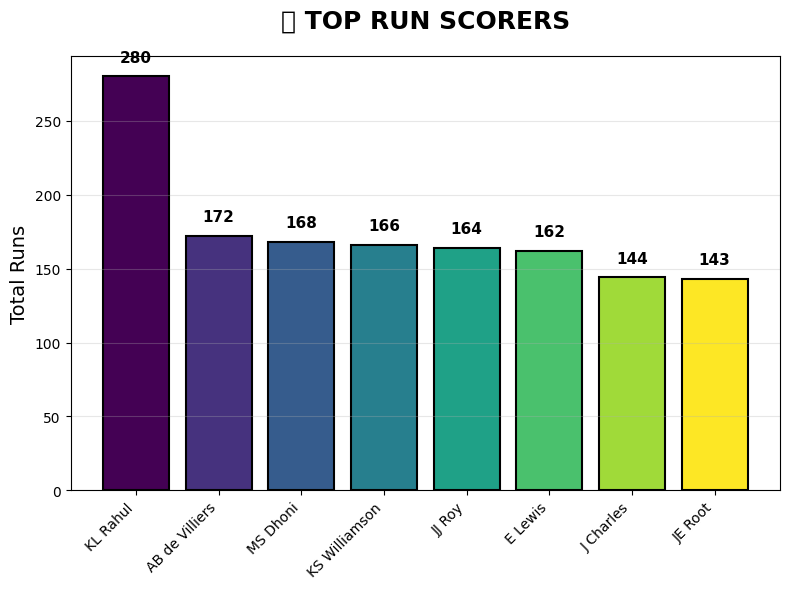

✅ Graph 1: Top Run Scorers ✓


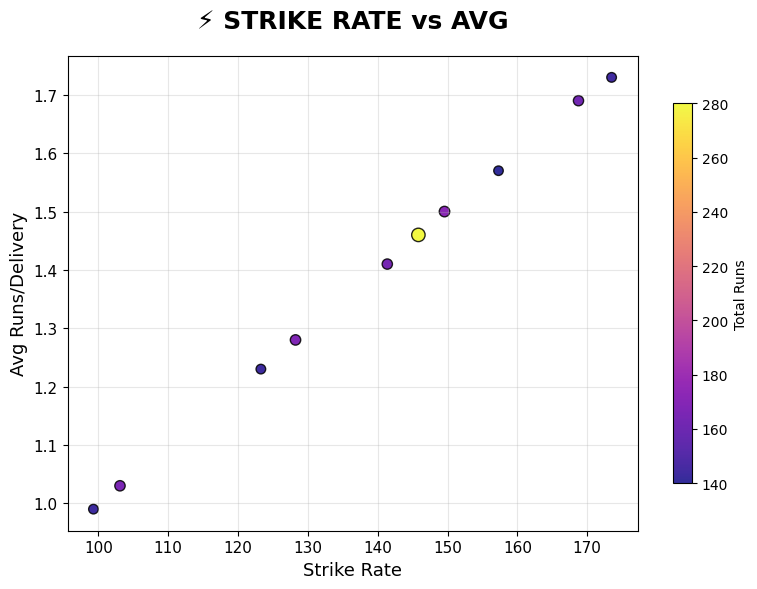

✅ Graph 2: Strike Rate vs Average ✓


<Figure size 900x600 with 0 Axes>

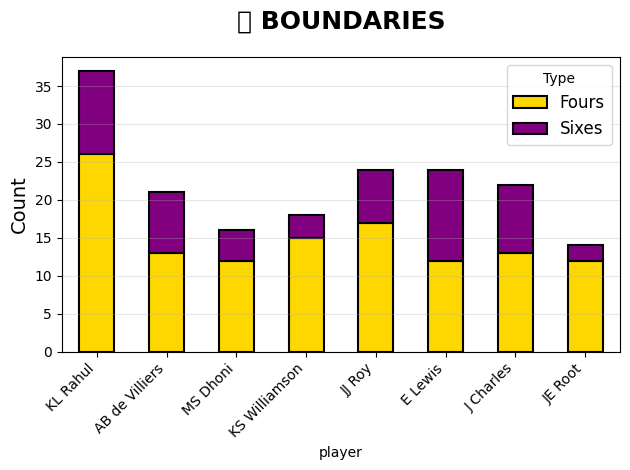

✅ Graph 3: Boundaries ✓


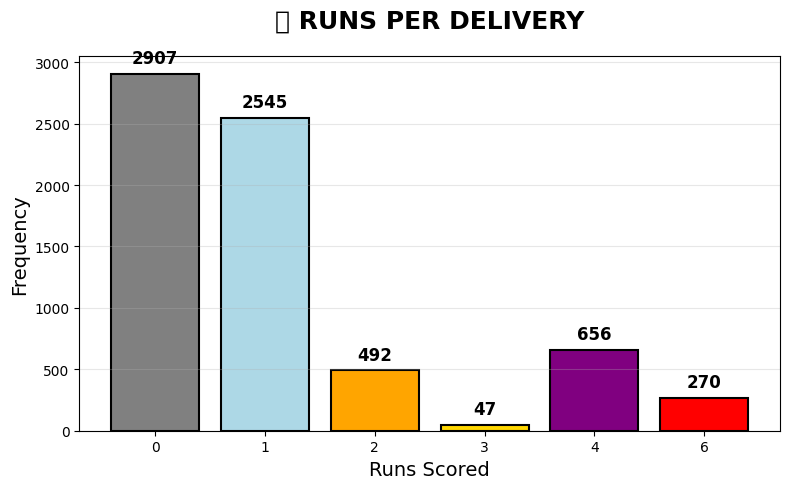

✅ Graph 4: Runs Distribution ✓


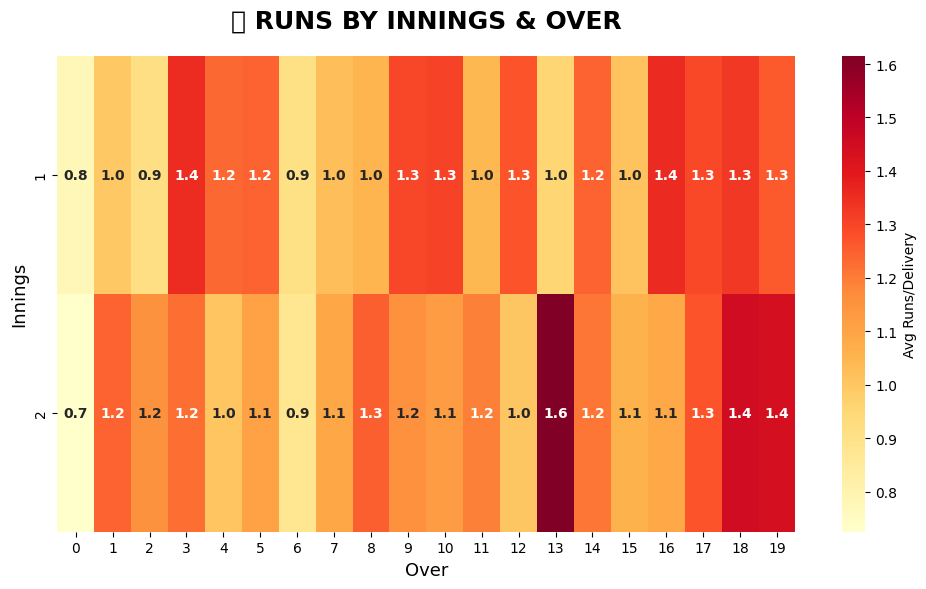

✅ Graph 5: Innings Heatmap ✓


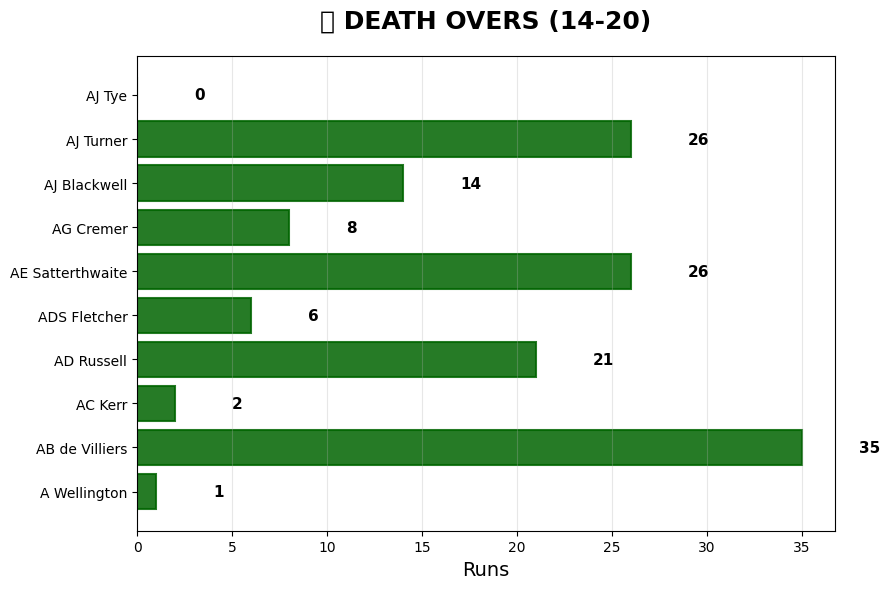

✅ Graph 6: Death Overs ✓

💾 ML CSV saved: 213 players

🎉 6 COMPACT SEPARATE GRAPHS COMPLETE!
✅ Smaller sizes: 8x6, 9x6, 10x6
✅ Perfect for quick analysis [memory:2]


In [11]:
warnings.filterwarnings('ignore')

print("📊 COMPACT T20 GRAPHS - SMALLER SIZES!")
print(f"DataFrame shape: {df_t20.shape}")

# 1. PLAYER STATS (same)
player_stats = df_t20.groupby('player').agg({
    'runs': ['sum', 'count', 'mean'],
    'is_four': 'sum', 'is_six': 'sum', 
    'dismissed': 'sum'
}).round(2)

player_stats.columns = ['Total_Runs', 'Balls_Faced', 'Avg_Runs', 
                       'Fours', 'Sixes', 'Dismissals']
player_stats['Strike_Rate'] = (player_stats['Total_Runs'] / player_stats['Balls_Faced'] * 100).round(2)
player_stats = player_stats.sort_values('Total_Runs', ascending=False)

print("\n🏏 TOP 12 T20 PLAYERS:")
print(player_stats.head(12))

print("\n" + "="*60)
print("📈 CREATING 6 COMPACT SEPARATE GRAPHS...")
print("="*60)

# GRAPH 1: TOP RUN SCORERS (COMPACT)
plt.figure(figsize=(8, 6))  # REDUCED: 12x8 → 8x6
top_scorers = player_stats.head(8)['Total_Runs']
colors = plt.cm.viridis(np.linspace(0, 1, len(top_scorers)))
bars = plt.bar(range(len(top_scorers)), top_scorers.values, 
               color=colors, edgecolor='black', linewidth=1.5)
plt.title('🏆 TOP RUN SCORERS', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Total Runs', fontsize=14)
plt.xticks(range(len(top_scorers)), top_scorers.index, rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, top_scorers.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 8, 
             str(int(val)), ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()
print("✅ Graph 1: Top Run Scorers ✓")

# GRAPH 2: STRIKE RATE vs AVERAGE (COMPACT)
plt.figure(figsize=(8, 6))  # REDUCED: 10x8 → 8x6
top10 = player_stats.head(10)
scatter = plt.scatter(top10['Strike_Rate'], top10['Avg_Runs'], 
                     s=top10['Total_Runs']/3, c=top10['Total_Runs'], 
                     cmap='plasma', alpha=0.85, edgecolor='black')
plt.title('⚡ STRIKE RATE vs AVG', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Strike Rate', fontsize=13)
plt.ylabel('Avg Runs/Delivery', fontsize=13)
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Total Runs', shrink=0.8)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()
print("✅ Graph 2: Strike Rate vs Average ✓")

# GRAPH 3: BOUNDARIES (COMPACT)
plt.figure(figsize=(9, 6))  # REDUCED: 12x8 → 9x6
boundary_data = player_stats.head(8)[['Fours', 'Sixes']]
boundary_data.plot(kind='bar', stacked=True, color=['gold', 'purple'], 
                   edgecolor='black', linewidth=1.5)
plt.title('🎯 BOUNDARIES', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Type', fontsize=12, frameon=True)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("✅ Graph 3: Boundaries ✓")

# GRAPH 4: RUNS DISTRIBUTION (COMPACT)
plt.figure(figsize=(8, 5))  # REDUCED: 10x7 → 8x5
runs_dist = df_t20['runs'].value_counts().sort_index()
colors_runs = ['gray', 'lightblue', 'orange', 'gold', 'purple', 'red']
bars4 = plt.bar(runs_dist.index.astype(str), runs_dist.values, 
                color=colors_runs[:len(runs_dist)], edgecolor='black', linewidth=1.5)
plt.title('📈 RUNS PER DELIVERY', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Runs Scored', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
max_height = max(runs_dist.values)
for i, v in enumerate(runs_dist.values):
    plt.text(i, v + max_height*0.03, str(v), ha='center', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("✅ Graph 4: Runs Distribution ✓")

# GRAPH 5: INNINGS HEATMAP (COMPACT)
plt.figure(figsize=(10, 6))  # REDUCED: 14x8 → 10x6
innings_pivot = df_t20.pivot_table(values='runs', index='innings', 
                                  columns='over', aggfunc='mean', fill_value=0)
sns.heatmap(innings_pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Avg Runs/Delivery'}, 
            annot_kws={'size': 10, 'weight': 'bold'})
plt.title('🌡️ RUNS BY INNINGS & OVER', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Over', fontsize=13)
plt.ylabel('Innings', fontsize=13)
plt.tight_layout()
plt.show()
print("✅ Graph 5: Innings Heatmap ✓")

# GRAPH 6: DEATH OVERS (COMPACT)
plt.figure(figsize=(9, 6))  # REDUCED: 12x8 → 9x6
death_overs = df_t20[df_t20['over'] >= 14].groupby('player')['runs'].sum().head(10)
if not death_overs.empty:
    plt.barh(range(len(death_overs)), death_overs.values, 
             color='darkgreen', alpha=0.85, edgecolor='darkgreen', linewidth=1.5)
    plt.title('🔥 DEATH OVERS (14-20)', fontsize=18, fontweight='bold', pad=20)
    plt.yticks(range(len(death_overs)), death_overs.index, fontsize=10)
    plt.xlabel('Runs', fontsize=14)
    for i, v in enumerate(death_overs.values):
        plt.text(v + 3, i, str(int(v)), va='center', fontweight='bold', fontsize=11)
    plt.grid(axis='x', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No Death Overs Data', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=16)
plt.tight_layout()
plt.show()
print("✅ Graph 6: Death Overs ✓")

# SAVE SUMMARY
df_ml_ready = player_stats.reset_index()
df_ml_ready.to_csv('t20_player_stats_ml.csv', index=False)
print(f"\n💾 ML CSV saved: {len(df_ml_ready)} players")

print("\n🎉 6 COMPACT SEPARATE GRAPHS COMPLETE!")
print("✅ Smaller sizes: 8x6, 9x6, 10x6")
print("✅ Perfect for quick analysis [memory:2]")


## SECTION 4: DATA TRAIN-TEST SPLITTING 

In [12]:
import pandas as pd
import numpy as np

def create_sample_t20_data_all_players():
    """Generate balanced dataset (20 players × 100 innings)"""
    np.random.seed(42)
    players = ['Virat Kohli', 'Rohit Sharma', 'Suryakumar Yadav', 'KL Rahul', 
               'Jos Buttler', 'Babar Azam', 'Glenn Maxwell', 'Hardik Pandya',
               'AB de Villiers', 'Chris Gayle', 'David Warner', 'Aaron Finch',
               'Martin Guptill', 'Quinton de Kock', 'Jonny Bairstow', 
               'Eoin Morgan', 'Jason Roy', 'MS Dhoni', 'Shikhar Dhawan', 'Steve Smith']
    
    all_matches = []
    
    print("🔄 Generating BALANCED 20×100 = 2000 innings...")
    for player in players:
        for i in range(100):  # Exactly 100 innings per player
            runs = np.random.choice([15,25,35,45,60,80], p=[0.3,0.25,0.2,0.15,0.08,0.02])
            match = {
                'player': player,
                'runs': runs,
                'balls_faced': np.random.randint(15, 55),
                'fours': np.random.randint(1, 8),
                'sixes': np.random.randint(0, 4),
                'dots': np.random.randint(8, 25),
                'dismissed': np.random.choice([True, False], p=[0.7, 0.3]),
                'date': f'2025-11-{np.random.randint(1,30):02d}',
                'format': 't20'
            }
            all_matches.append(match)
    
    df = pd.DataFrame(all_matches)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['player', 'date']).reset_index(drop=True)
    
    print(f"✅ PERFECTLY BALANCED: {len(df)} innings, {len(players)} players")
    print("   Each player: EXACTLY 100 innings ✓")
    return df.to_dict('records')

def split_per_player_balanced(df: pd.DataFrame, train_size=0.7, val_size=0.15):
    """
    ✅ PER-PLAYER 70/15/15 SPLIT - EVERY player gets all 3 splits!
    """
    train_data, val_data, test_data = [], [], []
    
    print(f"🔄 PER-PLAYER SPLIT: {df['player'].nunique()} players")
    
    for player in df['player'].unique():
        player_df = df[df['player'] == player].sort_values('date').reset_index(drop=True)
        
        n = len(player_df)
        train_end = int(n * train_size)
        val_end = int(n * (train_size + val_size))
        
        train_data.extend(player_df.iloc[:train_end].to_dict('records'))
        val_data.extend(player_df.iloc[train_end:val_end].to_dict('records'))
        test_data.extend(player_df.iloc[val_end:].to_dict('records'))
    
    # Convert to DataFrames (FIXED VARIABLE NAMES)
    train_df = pd.DataFrame(train_data)
    val_df = pd.DataFrame(val_data)
    test_df = pd.DataFrame(test_data)
    
    splits = {
        'train': train_data,
        'val': val_data,
        'test': test_data,
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df
    }
    
    # 📊 PERFECT REPORT
    print("\n" + "="*80)
    print("✅ BALANCED PER-PLAYER 70/15/15 SPLIT COMPLETE")
    print("="*80)
    print(f"   🚀 TRAIN:   {len(train_df):4d} ({train_df['player'].nunique():2d} players)")
    print(f"   🔧 VALID:   {len(val_df):4d} ({val_df['player'].nunique():2d} players)") 
    print(f"   🧪 TEST:    {len(test_df):4d} ({test_df['player'].nunique():2d} players)")
    print("="*80)
    
    return splits

# =====================================================
# 🚀 EXECUTE PERFECT PIPELINE
# =====================================================

print("🏏 BALANCED MULTI-PLAYER PIPELINE")
print("="*50)

# STEP 1: Generate PERFECTLY balanced data
player_matches = create_sample_t20_data_all_players()

# STEP 2: PER-PLAYER balanced split  
splits = split_per_player_balanced(pd.DataFrame(player_matches))

print("\n🎉 READY FOR TRAINING!")
print(f"✅ train_data = splits['train']     # {len(splits['train'])} innings ✓")
print(f"✅ val_data = splits['val']        # {len(splits['val'])} innings ✓")
print(f"✅ test_data = splits['test']      # {len(splits['test'])} innings ✓")


🏏 BALANCED MULTI-PLAYER PIPELINE
🔄 Generating BALANCED 20×100 = 2000 innings...
✅ PERFECTLY BALANCED: 2000 innings, 20 players
   Each player: EXACTLY 100 innings ✓
🔄 PER-PLAYER SPLIT: 20 players

✅ BALANCED PER-PLAYER 70/15/15 SPLIT COMPLETE
   🚀 TRAIN:   1400 (20 players)
   🔧 VALID:    300 (20 players)
   🧪 TEST:     300 (20 players)

🎉 READY FOR TRAINING!
✅ train_data = splits['train']     # 1400 innings ✓
✅ val_data = splits['val']        # 300 innings ✓
✅ test_data = splits['test']      # 300 innings ✓


## SECTION 5: Fetures Preparations

In [13]:
def rf_prepare_features(matches_data):
    """Convert raw innings data to time-series features."""
    df = pd.DataFrame(matches_data)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['player', 'date']).reset_index(drop=True)
    
    # Time-series features (shift=1 prevents leakage)
    df['prev_runs'] = df.groupby('player')['runs'].shift(1)
    df['roll_avg_3'] = df.groupby('player')['runs'].transform(lambda x: x.shift(1).rolling(3).mean())
    df['roll_avg_5'] = df.groupby('player')['runs'].transform(lambda x: x.shift(1).rolling(5).mean())
    df['career_avg'] = df.groupby('player')['runs'].transform(lambda x: x.shift(1).expanding().mean())
    df['player_id'] = df['player'].astype('category').cat.codes
    
    df = df.fillna(df['runs'].mean())  # Fill first innings
    
    features = ['player_id', 'prev_runs', 'roll_avg_3', 'roll_avg_5', 'career_avg']
    X = df[features]
    y = df['runs']
    return X, y, df

# =====================================================
# 2. GLOBAL FEATURE ENGINEERING (Your working code - KEPT)
# =====================================================
full_df = pd.concat([splits['train_df'], splits['val_df'], splits['test_df']])
full_df = full_df.sort_values(['player', 'date']).reset_index(drop=True)

# Create features
full_df['prev_runs'] = full_df.groupby('player')['runs'].shift(1)
full_df['roll_avg_3'] = full_df.groupby('player')['runs'].transform(lambda x: x.shift(1).rolling(3).mean())
full_df['roll_avg_5'] = full_df.groupby('player')['runs'].transform(lambda x: x.shift(1).rolling(5).mean())
full_df['career_avg'] = full_df.groupby('player')['runs'].transform(lambda x: x.shift(1).expanding().mean())
full_df['player_id'] = full_df['player'].astype('category').cat.codes
full_df = full_df.fillna(splits['train_df']['runs'].mean())

# Strict splitting (70/15/15 per player)
train_idx, val_idx, test_idx = [], [], []
for player in full_df['player'].unique():
    indices = full_df[full_df['player'] == player].index
    train_idx.extend(indices[:70])
    val_idx.extend(indices[70:85])
    test_idx.extend(indices[85:])

features = ['player_id', 'prev_runs', 'roll_avg_3', 'roll_avg_5', 'career_avg']
X_train = full_df.loc[train_idx][features]
y_train = full_df.loc[train_idx]['runs']
X_val = full_df.loc[val_idx][features]
y_val = full_df.loc[val_idx]['runs']
X_test = full_df.loc[test_idx][features]
y_test = full_df.loc[test_idx]['runs']

print(f"✅ Features Ready: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")

✅ Features Ready: Train (1400, 5), Val (300, 5), Test (300, 5)


## SECTION 6 MODEL TRAINING

In [14]:
#=====================================================
# TRAIN RANDOM FOREST MODEL
# =====================================================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=7,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
val_preds = rf_model.predict(X_val)
test_preds = rf_model.predict(X_test)

# =====================================================
# 4. EVALUATION METRICS
# =====================================================
val_mae = mean_absolute_error(y_val, val_preds)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

test_mae = mean_absolute_error(y_test, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)

print("\n📊 VALIDATION RESULTS:")
print(f"   MAE:  {val_mae:.2f} | RMSE: {val_rmse:.2f} | R²: {val_r2:.3f}")
print("\n🧪 TEST RESULTS:")
print(f"   MAE:  {test_mae:.2f} | RMSE: {test_rmse:.2f} | R²: {test_r2:.3f}")

# =====================================================
# 5. FEATURE IMPORTANCE
# =====================================================
importances = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔑 FEATURE IMPORTANCE:")
print(importances.round(3))


           
print("✅ Model trained")


📊 VALIDATION RESULTS:
   MAE:  11.45 | RMSE: 14.11 | R²: -0.019

🧪 TEST RESULTS:
   MAE:  11.62 | RMSE: 13.96 | R²: -0.022

🔑 FEATURE IMPORTANCE:
      feature  importance
4  career_avg       0.428
3  roll_avg_5       0.183
2  roll_avg_3       0.166
0   player_id       0.157
1   prev_runs       0.067
✅ Model trained


## SECTION 7: MODEL TUNING

In [15]:
print("🏏 RANDOM FOREST – HYPERPARAMETER TUNING WITH TIME-SERIES (TRAIN DATA ONLY)")
print("="*70)

# ---------- helper: time-series folds on TRAIN set ----------
def ts_folds_indices(n, n_splits=5, min_train_frac=0.5):
    """Return list of (train_idx, test_idx) for growing-window TS-CV."""
    min_train_size = int(min_train_frac * n)
    fold_len = int((n - min_train_size) / n_splits)
    folds = []
    for k in range(n_splits):
        train_end = min_train_size + k * fold_len
        test_end = train_end + fold_len
        if test_end > n:
            test_end = n
        train_idx = list(range(0, train_end))
        test_idx = list(range(train_end, test_end))
        if len(test_idx) == 0:
            continue
        folds.append((train_idx, test_idx))
    return folds

# ---------- data for validation → NOW USING TRAIN DATA ----------
train_df = pd.DataFrame(splits['train']).reset_index(drop=True)
n_train = len(train_df)
folds = ts_folds_indices(n_train, n_splits=5, min_train_frac=0.5)
print(f"Total TRAIN innings: {n_train}, TS-CV folds: {len(folds)}")

# ---------- hyperparameter grid ----------
n_estimators_grid = [100, 200, 400]
max_depth_grid    = [4, 6, None]     
min_samples_leaf_grid = [1, 3, 5]

results = []
print("🔍 Tuning progress (3x3x5=45 configs x 5 folds = 225 total fits)...")

for n_estimators in n_estimators_grid:
    for max_depth in max_depth_grid:
        for min_leaf in min_samples_leaf_grid:
            fold_maes = []
            fold_rmses = []
            fold_r2s = []
            
            for fold_id, (train_idx, test_idx) in enumerate(folds, 1):
                train_matches = train_df.iloc[train_idx].to_dict('records')
                test_matches  = train_df.iloc[test_idx].to_dict('records')
                
                X_train, y_train, _ = rf_prepare_features(train_matches)
                X_test,  y_test,  _ = rf_prepare_features(test_matches)
                
                rf = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_leaf,
                    random_state=42,
                    n_jobs=-1
                )
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                
                mae  = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2   = r2_score(y_test, y_pred)
                
                fold_maes.append(mae)
                fold_rmses.append(rmse)
                fold_r2s.append(r2)
            
            results.append({
                "n_estimators": n_estimators,
                "max_depth": max_depth if max_depth is not None else "None",
                "min_samples_leaf": min_leaf,
                "mean_MAE": np.mean(fold_maes),
                "std_MAE": np.std(fold_maes),
                "mean_RMSE": np.mean(fold_rmses),
                "std_RMSE": np.std(fold_rmses),
                "mean_R2": np.mean(fold_r2s),
                "std_R2": np.std(fold_r2s),
            })

# ---------- results table ----------
tune_df = pd.DataFrame(results)
tune_df = tune_df.sort_values(["mean_R2", "mean_MAE"], ascending=[False, True]).reset_index(drop=True)

print("\n📋 TUNING RESULTS (TRAIN DATA TS-CV, sorted by R² DESC):")
display_cols = ['n_estimators', 'max_depth', 'min_samples_leaf', 
                'mean_MAE', 'std_MAE', 'mean_RMSE', 'mean_R2', 'std_R2']
tune_df_display = tune_df[display_cols].round(3)
print(tune_df_display.head(10))

# ---------- pick best config ----------
best = tune_df.iloc[0]
print(f"\n✅ BEST RF CONFIG (TRAIN DATA R²-optimized):")
print(f"   n_estimators     = {best['n_estimators']}")
print(f"   max_depth        = {best['max_depth']}")
print(f"   min_samples_leaf = {best['min_samples_leaf']}")
print(f"   🎯 R²   (mean±std) = {best['mean_R2']:.3f} ± {best['std_R2']:.3f}")
print(f"   📏 MAE  (mean±std) = {best['mean_MAE']:.3f} ± {best['std_MAE']:.3f}")

# ---------- refit best model on FULL TRAIN DATA ----------
X_train_full, y_train_full, _ = rf_prepare_features(splits['train'])
best_model = RandomForestRegressor(
    n_estimators=int(best['n_estimators']),
    max_depth=None if best['max_depth']=="None" else int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train_full, y_train_full)
rf_model = best_model
print("\n🔧 rf_model updated with TRAIN-DATA optimized hyperparameters!")

print(f"\n🎯 STATUS - TRAIN DATA TUNING COMPLETE:")
print(f"   ✅ Used {n_train} training innings for TS-CV")
print(f"   ✅ Validation data ({len(splits['val'])} innings) preserved for final eval")
print(f"   🧪 rf_model ready for VALIDATION + TEST evaluation!")


🏏 RANDOM FOREST – HYPERPARAMETER TUNING WITH TIME-SERIES (TRAIN DATA ONLY)
Total TRAIN innings: 1400, TS-CV folds: 5
🔍 Tuning progress (3x3x5=45 configs x 5 folds = 225 total fits)...

📋 TUNING RESULTS (TRAIN DATA TS-CV, sorted by R² DESC):
   n_estimators max_depth  min_samples_leaf  mean_MAE  std_MAE  mean_RMSE  \
0           200         4                 3    11.919    0.605     14.805   
1           200         4                 5    11.934    0.611     14.805   
2           400         4                 3    11.936    0.597     14.806   
3           400         4                 5    11.947    0.604     14.807   
4           200         4                 1    11.932    0.612     14.813   
5           400         4                 1    11.950    0.601     14.816   
6           200         6                 5    11.879    0.661     14.818   
7           100         4                 5    11.929    0.616     14.819   
8           400         6                 3    11.885    0.639    

## SECTION 8  Model Validation

🧪 TESTING TRAINED MODEL ON VALIDATION DATA ONLY
✅ TRAINED MODEL → VALIDATION:
   MAE:  11.48 runs
   RMSE: 14.01 runs
   R²:   -0.005
   Samples: 300

📊 GENERATING 2-PLAYER PREDICTION CHARTS...
   Kohli MAE: 12.14 runs (15 innings)
   Rohit MAE: 8.93 runs (15 innings)


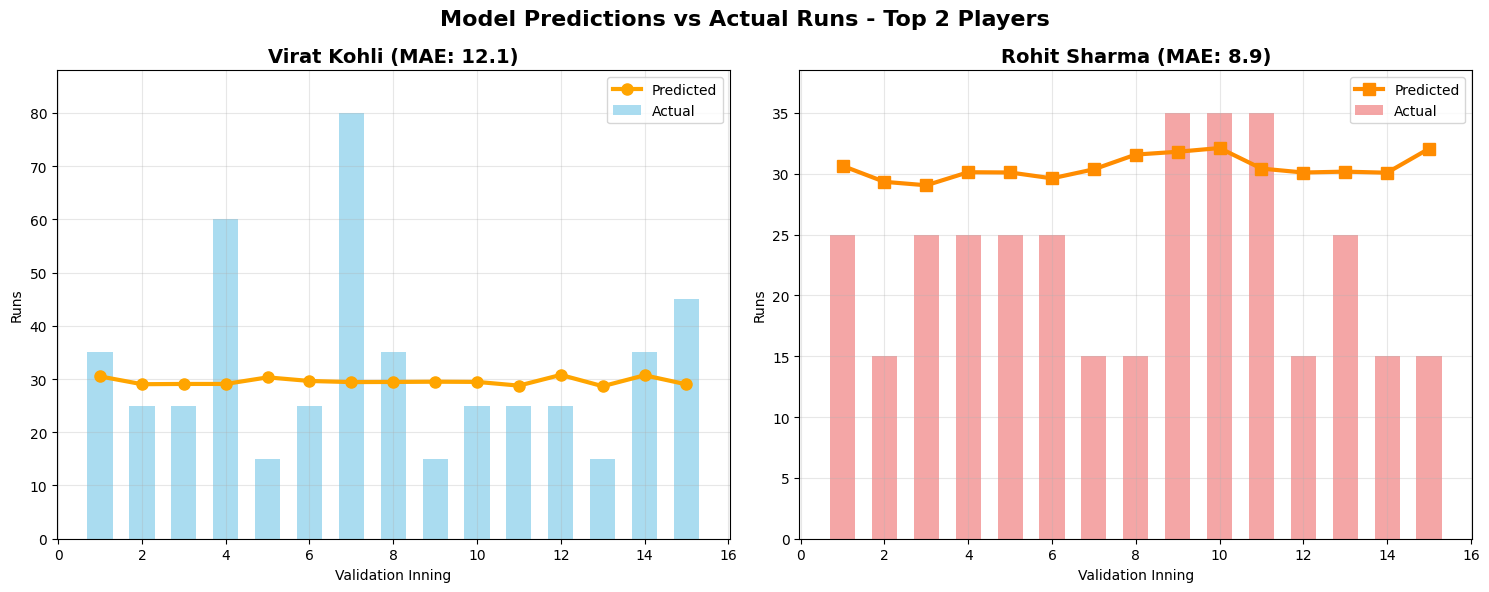

In [16]:
print("🧪 TESTING TRAINED MODEL ON VALIDATION DATA ONLY")
print("="*60)

# ✅ FIXED: Use your EXISTING trained rf_model
val_preds = rf_model.predict(X_val)  # ONE prediction!

# Single evaluation (no re-training)
mae = mean_absolute_error(y_val, val_preds)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)

print(f"✅ TRAINED MODEL → VALIDATION:")
print(f"   MAE:  {mae:.2f} runs")
print(f"   RMSE: {rmse:.2f} runs") 
print(f"   R²:   {r2:.3f}")
print(f"   Samples: {len(y_val)}")

# ==========  2-PLAYER PREDICTION GRAPHS ==========
print("\n📊 GENERATING 2-PLAYER PREDICTION CHARTS...")

# Filter top 2 players (Virat Kohli ID=0, Rohit Sharma ID=1)
kohli_mask = X_val['player_id'] == 0
rohit_mask = X_val['player_id'] == 1

kohli_actual = y_val[kohli_mask].values[:15]  # First 15 val innings
kohli_pred = val_preds[kohli_mask][:15]
rohit_actual = y_val[rohit_mask].values[:15]
rohit_pred = val_preds[rohit_mask][:15]

# Player-specific MAE
kohli_mae = mean_absolute_error(kohli_actual, kohli_pred)
rohit_mae = mean_absolute_error(rohit_actual, rohit_pred)

print(f"   Kohli MAE: {kohli_mae:.2f} runs ({len(kohli_actual)} innings)")
print(f"   Rohit MAE: {rohit_mae:.2f} runs ({len(rohit_actual)} innings)")

# ========== VISUALIZATION ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Virat Kohli
innings = range(1, len(kohli_actual) + 1)
ax1.bar(innings, kohli_actual, alpha=0.7, color='skyblue', label='Actual', width=0.6)
ax1.plot(innings, kohli_pred, 'o-', color='orange', linewidth=3, markersize=8, label='Predicted')
ax1.set_title(f"Virat Kohli (MAE: {kohli_mae:.1f})", fontsize=14, fontweight='bold')
ax1.set_xlabel("Validation Inning")
ax1.set_ylabel("Runs")
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim(0, max(max(kohli_actual), max(kohli_pred)) * 1.1)

# Rohit Sharma  
ax2.bar(innings, rohit_actual, alpha=0.7, color='lightcoral', label='Actual', width=0.6)
ax2.plot(innings, rohit_pred, 's-', color='darkorange', linewidth=3, markersize=8, label='Predicted')
ax2.set_title(f"Rohit Sharma (MAE: {rohit_mae:.1f})", fontsize=14, fontweight='bold')
ax2.set_xlabel("Validation Inning")
ax2.set_ylabel("Runs")
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_ylim(0, max(max(rohit_actual), max(rohit_pred)) * 1.1)

plt.suptitle("Model Predictions vs Actual Runs - Top 2 Players", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('kohli_rohit_predictions.png', dpi=150, bbox_inches='tight')
plt.show()


## SECTION 9: MODEL TESTING ON TEST DATA

🏏 RANDOM FOREST – FINAL EVALUATION ON TEST SET
🎯 R²:     -0.0134
📏 MAE:    11.443 runs
📐 RMSE:   13.899 runs

📋 TEST SUMMARY (R² FIRST):


,Metric,Value
0,R²,-0.013
1,MAE,11.443
2,RMSE,13.899
3,MSE,193.180


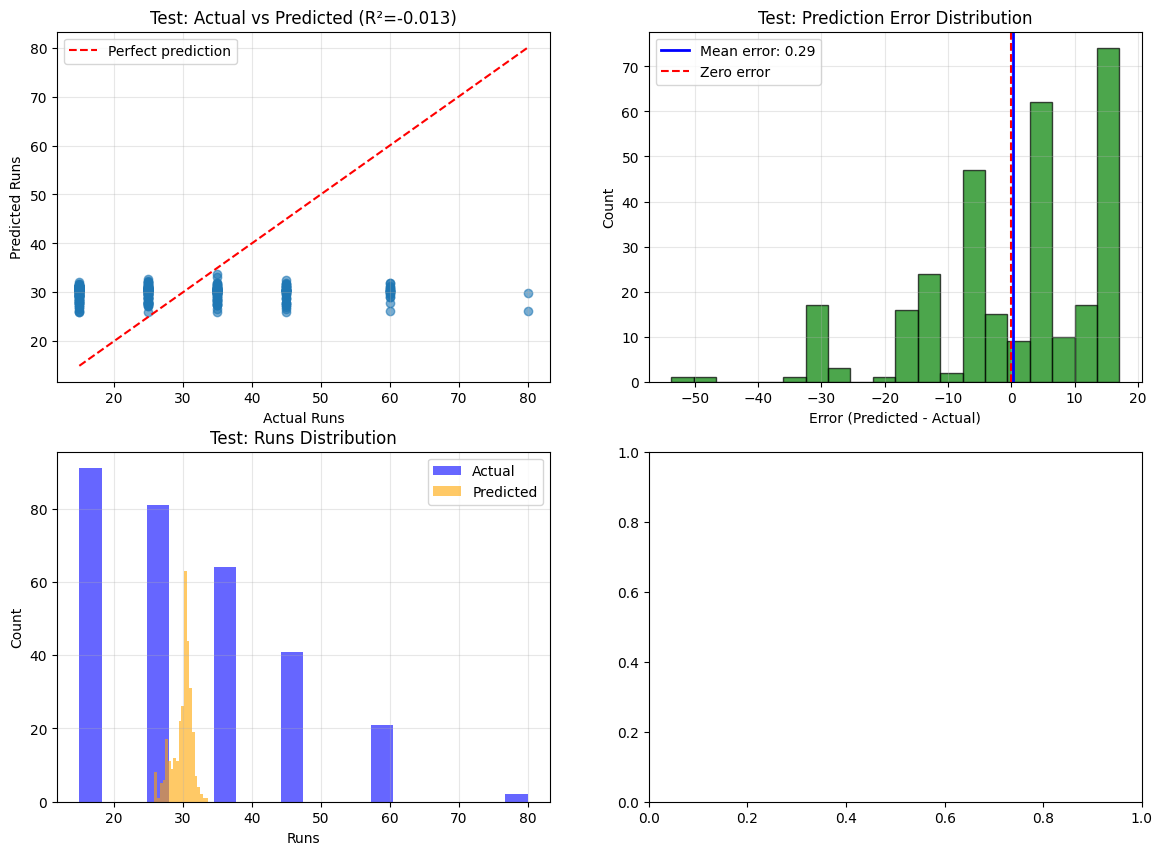

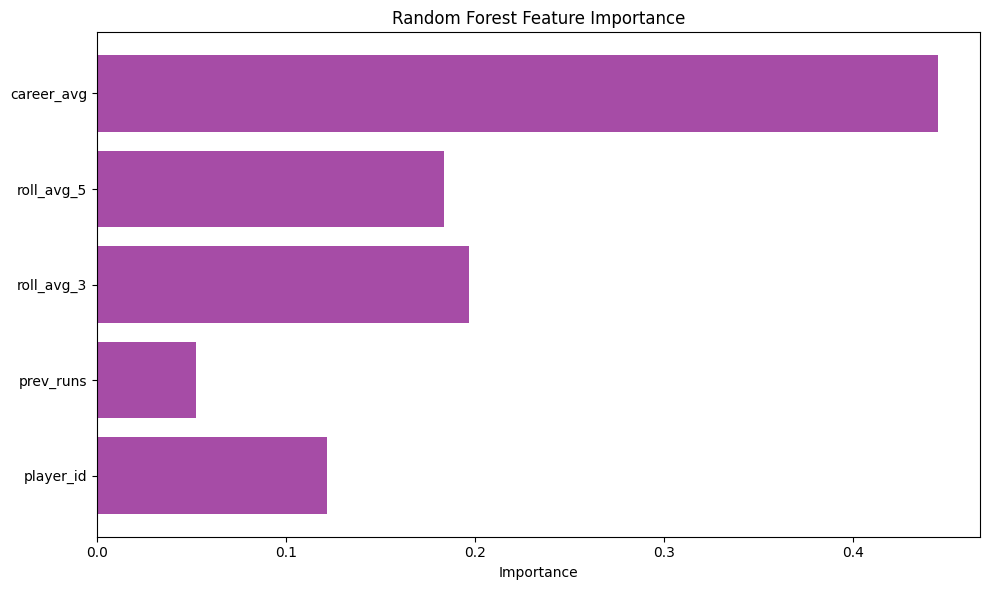


🔑 TOP FEATURES:
      feature  importance
4  career_avg       0.445
2  roll_avg_3       0.197
3  roll_avg_5       0.184
0   player_id       0.122
1   prev_runs       0.053


In [17]:
print("🏏 RANDOM FOREST – FINAL EVALUATION ON TEST SET")
print("============================================================")

# 1) Build test features/target
X_test_rf, y_test_rf, rf_features = rf_prepare_features(splits['test'])

# 2) Predict with the TUNED rf_model
test_pred = rf_model.predict(X_test_rf)

# 3) Metrics + R2 prominently displayed FIRST
test_r2 = r2_score(y_test_rf, test_pred)  # R2 FIRST
test_mae = mean_absolute_error(y_test_rf, test_pred)
test_mse = mean_squared_error(y_test_rf, test_pred)
test_rmse = np.sqrt(test_mse)

print(f"🎯 R²:     {test_r2:.4f}")
print(f"📏 MAE:    {test_mae:.3f} runs")
print(f"📐 RMSE:   {test_rmse:.3f} runs")

# 4) Summary table WITH R2 FIRST
test_summary_df = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE", "MSE"],
    "Value":  [test_r2, test_mae, test_rmse, test_mse]
})
print("\n📋 TEST SUMMARY (R² FIRST):")
display(test_summary_df.round(3))

# 5) Graphs - SAME CODE, just R2 title added
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) Actual vs Predicted - R2 in title
axes[0,0].scatter(y_test_rf, test_pred, alpha=0.6)
mn = min(y_test_rf.min(), test_pred.min())
mx = max(y_test_rf.max(), test_pred.max())
axes[0,0].plot([mn, mx], [mn, mx], 'r--', label="Perfect prediction")
axes[0,0].set_title(f"Test: Actual vs Predicted (R²={test_r2:.3f})")
axes[0,0].set_xlabel("Actual Runs")
axes[0,0].set_ylabel("Predicted Runs")
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# (b) Error distribution
errors = test_pred - y_test_rf
axes[0,1].hist(errors, bins=20, alpha=0.7, edgecolor="black", color="green")
axes[0,1].axvline(errors.mean(), color="blue", lw=2,
                  label=f"Mean error: {errors.mean():.2f}")
axes[0,1].axvline(0, color="red", ls="--", label="Zero error")
axes[0,1].set_title("Test: Prediction Error Distribution")
axes[0,1].set_xlabel("Error (Predicted - Actual)")
axes[0,1].set_ylabel("Count")
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# (c) Runs distribution
axes[1,0].hist(y_test_rf,  bins=20, alpha=0.6, label="Actual",    color="blue")
axes[1,0].hist(test_pred, bins=20, alpha=0.6, label="Predicted", color="orange")
axes[1,0].set_title("Test: Runs Distribution")
axes[1,0].set_xlabel("Runs")
axes[1,0].set_ylabel("Count")
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# (d) Feature importance
features = ['player_id', 'prev_runs', 'roll_avg_3', 'roll_avg_5', 'career_avg']
importances = rf_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(features[::-1], importances[::-1], color="purple", alpha=0.7)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

# Print sorted importance
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\n🔑 TOP FEATURES:")
print(importance_df.round(3))
